In [22]:
import glob
import numpy
import pandas
import seaborn
import matplotlib.pyplot as plt
import multiprocessing as mp
import os
from build import build_model
import coralme
from tqdm import tqdm

In [23]:
from IPython.display import display, HTML, Math, Markdown
display(HTML("<style>.container { width:95% !important; }</style>"))

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load

In [24]:
def load_data(path):
    try:
        df = pandas.read_csv(path,index_col=0)[["fluxes"]]
    except:
        df = pandas.DataFrame(columns=["fluxes"])
    df.columns = [org]
    return df

In [25]:
dataset = ""

In [26]:
# overflow = {}
# for f in os.listdir("./datasets/"):
#     if "3.5." not in f:
#         continue
#     if "overflow" not in f or "all" in f:
#         continue
#     c = f.replace("_overflow.csv","").replace("3.5.","")
#     overflow[c] = pandas.read_csv("./datasets/"+f,index_col=0)

In [27]:
conditions = ["IBD","nonIBD"]
organisms = set(pandas.read_csv("biomass_constrained.txt",index_col=0,header=None).index.to_list())
fluxes = {i:pandas.DataFrame() for i in conditions}
for org in tqdm(organisms):
    for c in conditions:
        tmp = load_data("./cases/fluxes/{}{}/{}.csv".format(c,dataset,org))
        tmp = tmp.loc[[i for i in tmp.index if i.startswith("EX_")]]
        fluxes[c] = pandas.concat([fluxes[c],tmp], axis=1).fillna(0)

100%|██████████| 495/495 [00:04<00:00, 107.28it/s]


In [28]:
predictions = {
    "fluxes" : fluxes,
    "growth" : pandas.read_csv("./datasets/3.5.IBD{}_growth_rates.csv".format(dataset),index_col=0)
}

In [29]:
# RelativeAbundances = pandas.read_csv("./ibdmdb/metaG_per_diagnosis.csv",index_col=0)
RelativeAbundances = pandas.read_csv("./ibdmdb/Referenced_metaG_per_diagnosis.csv",index_col=0)

In [30]:
# # Yields
# for c in predictions["growth"].columns:
#     predictions["fluxes"][c] = predictions["fluxes"][c].div(predictions["growth"][c],axis=1)

In [31]:
FluxesByOrganism = {}
for c in predictions["growth"].columns:
    tmp = predictions["fluxes"][c].multiply(RelativeAbundances[c],axis=1)
    FluxesByOrganism[c] = tmp[tmp.any(axis=1)]
# results.fillna(0.,inplace=True)

In [32]:
for k,v in FluxesByOrganism.items():
    v.to_csv("./datasets/3.6.TotalFluxes_{}{}.csv".format(k,dataset))

In [33]:
TotalFluxes = pandas.DataFrame()
for k,v in FluxesByOrganism.items():
    TotalFluxes[k] = v.sum(axis=1)

In [34]:
Producing = TotalFluxes.copy()
Producing[Producing<1e-16] = 0
Producing = Producing[Producing.any(axis=1)]

In [35]:
Consuming = TotalFluxes.copy()
Consuming[Consuming>-1e-16] = 0
Consuming = Consuming[Consuming.any(axis=1)].abs()

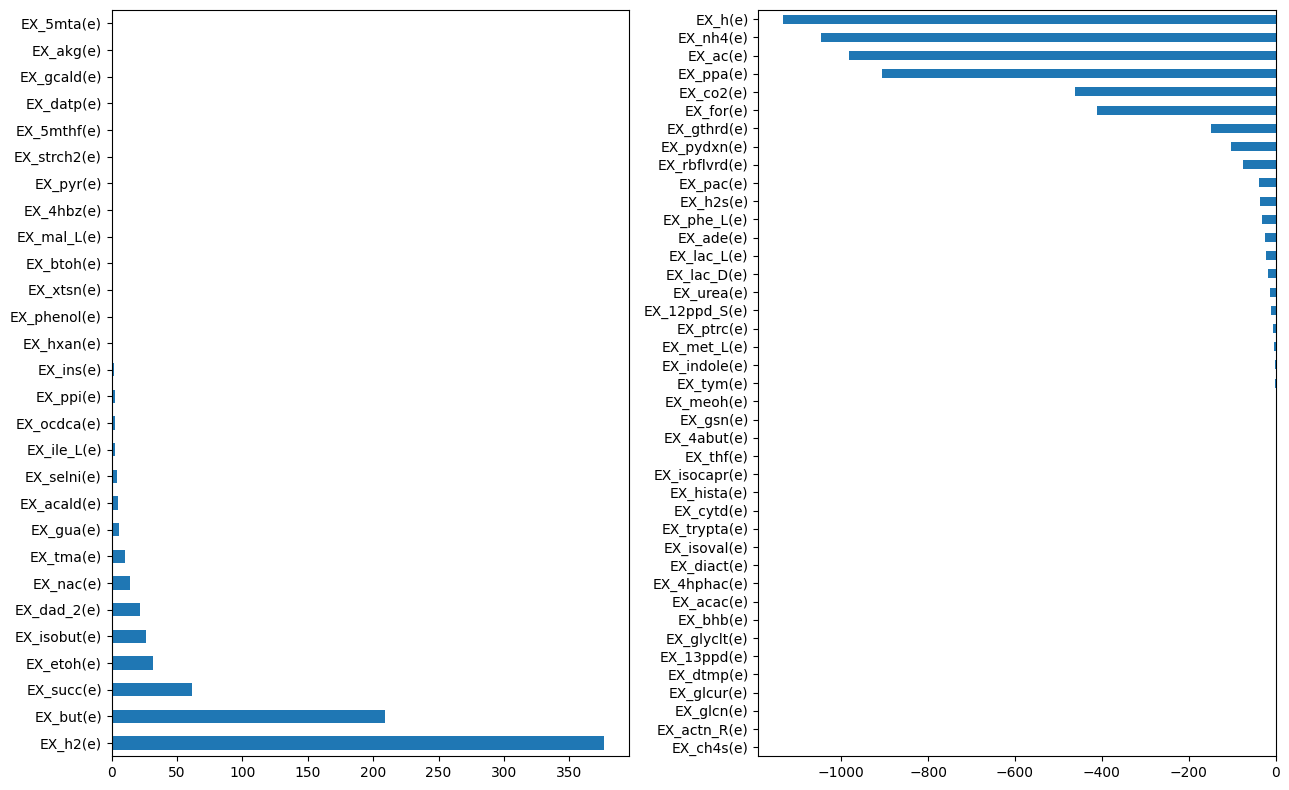

In [36]:
fig,ax = plt.subplots(1,2,figsize=(13,8))
tmp1 = (Producing["IBD"] - Producing["nonIBD"])
# tmp = numpy.log10(tmp)
(tmp1[tmp1>0.001]).sort_values(ascending=False).plot.barh(ax=ax[0])
(tmp1[tmp1<-0.001]).sort_values(ascending=False).plot.barh(ax=ax[1])
fig.tight_layout()

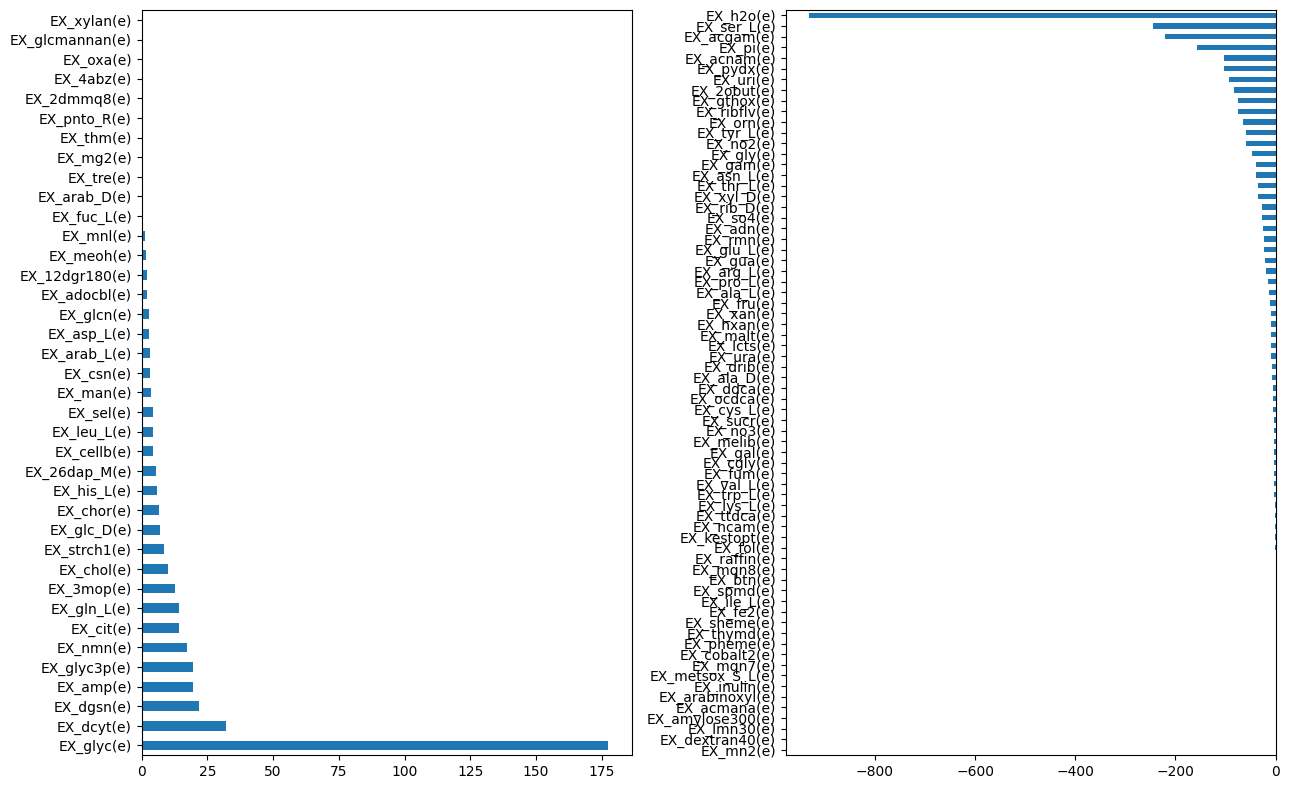

In [37]:
fig,ax = plt.subplots(1,2,figsize=(13,8))
tmp2 = (Consuming["IBD"] - Consuming["nonIBD"])
# tmp = numpy.log10(tmp)
(tmp2[tmp2>0.001]).sort_values(ascending=False).plot.barh(ax=ax[0])
(tmp2[tmp2<-0.001]).sort_values(ascending=False).plot.barh(ax=ax[1])
fig.tight_layout()

In [38]:
Deltas = pandas.DataFrame()
Deltas.index = ["{}_prod".format(r) for r,f in tmp1.items()] + ["{}_cons".format(r) for r,f in tmp2.items()]
Deltas["Rank"] = [abs(f) for r,f in tmp1.items()] + [f for r,f in tmp2.items()]
Deltas = Deltas.sort_values("Rank")

### Changes in growth rate

In [39]:
taxonomy = pandas.read_csv("./taxonomy.txt",index_col=0,sep='\t').drop("NCBI Taxonomy ID",axis=1)
taxonomy = taxonomy[taxonomy["Kingdom"]=="Bacteria"]

In [40]:
Growth = predictions["growth"]

In [41]:
Growth = pandas.concat([Growth,taxonomy],axis=1).dropna()

In [42]:
Growth.groupby("Genus").mean().loc["Bacteroides"]

/tmp/ipykernel_43091/133054104.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Growth.groupby("Genus").mean().loc["Bacteroides"]


nonIBD    0.102592
IBD       0.198442
Name: Bacteroides, dtype: float64